In [3]:
import pandas as pd
from ast import literal_eval
import nltk
import re
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [38]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr, spearmanr
from gensim.models.doc2vec import Doc2Vec
import requests
from nltk.tokenize import sent_tokenize, word_tokenize

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Viktor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
# scipy is needed in the version 1.10.1
#pip freeze | findstr scipy

# Load Datasets

We load the preprocessed datasets. Make sure to run the previous notebooks first, so the files are present.

## media

In [6]:
df_media = pd.read_csv('../data/cleantech-media.csv', converters={"token_content": literal_eval}, parse_dates=['date'])
df_media.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9588 entries, 0 to 9587
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   title          9588 non-null   object        
 1   date           9588 non-null   datetime64[ns]
 2   author         31 non-null     object        
 3   content        9588 non-null   object        
 4   domain         9588 non-null   object        
 5   url            9588 non-null   object        
 6   token_content  9588 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usage: 524.5+ KB


In [7]:
df_media.head(5)

title       date author  \
0  Qatar to Slash Emissions as LNG Expansion Adva... 2021-01-13    NaN   
1               India Launches Its First 700 MW PHWR 2021-01-15    NaN   
2              New Chapter for US-China Energy Trade 2021-01-20    NaN   
3  Japan: Slow Restarts Cast Doubt on 2030 Energy... 2021-01-22    NaN   
4     NYC Pension Funds to Divest Fossil Fuel Shares 2021-01-25    NaN   

                                             content       domain  \
0  Qatar Petroleum ( QP) is targeting aggressive ...  energyintel   
1  Nuclear Power Corp. of India Ltd. ( NPCIL) syn...  energyintel   
2  New US President Joe Biden took office this we...  energyintel   
3  The slow pace of Japanese reactor restarts con...  energyintel   
4  Two of New York City's largest pension funds s...  energyintel   

                                                 url  \
0  https://www.energyintel.com/0000017b-a7dc-de4c...   
1  https://www.energyintel.com/0000017b-a7dc-de4c...   
2  https://www.energyintel.com/0000017b-a7dc-de4c...   
3  https://www.energyintel.com/0000017b-a7dc-de4c...   
4  https://www.energyintel.com/0000017b-a7dc-de4c...   

                                       token_content  
0  [qatar, petroleum, qp, target, aggress, cut, g...  
1  [nuclear, power, corp, india, ltd, npcil, sync...  
2  [new, us, presid, joe, biden, take, offic, wee...  
3  [slow, pace, japanes, reactor, restart, contin...  
4  [two, new, york, citi, larg, pension, fund, sa...

## patents

In [8]:
df_patents = pd.read_csv('../data/google_patents.csv', converters={"token_content": literal_eval}, parse_dates=['publication_date'])
df_patents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13199 entries, 0 to 13198
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   publication_number  13199 non-null  object        
 1   application_number  13199 non-null  object        
 2   country_code        13199 non-null  object        
 3   publication_date    13199 non-null  datetime64[ns]
 4   inventor            13199 non-null  object        
 5   title               13199 non-null  object        
 6   abstract            13199 non-null  object        
 7   abstract_lang       13199 non-null  object        
 8   token_content       13199 non-null  object        
dtypes: datetime64[ns](1), object(8)
memory usage: 928.2+ KB


In [9]:
df_patents.head()

publication_number application_number country_code publication_date  \
0   US-2022239235-A1  US-202217717397-A           US       2022-07-28   
1   US-2022239251-A1  US-202217580956-A           US       2022-07-28   
2     US-11396827-B2  US-202117606042-A           US       2022-07-26   
3     CN-114772674-A  CN-202210500131-A           CN       2022-07-22   
4     CN-217026795-U  CN-202220668705-U           CN       2022-07-22   

  inventor                                              title  \
0       []  Adaptable DC-AC Inverter Drive System and Oper...   
1       []  System for providing the energy from a single ...   
2       []  Control method for optimizing solar-to-power e...   
3       []  Low-carbon running saline wastewater treatment...   
4       []  Water ecological remediation device convenient...   

                                            abstract abstract_lang  \
0  Disclosed is an adaptable DC-AC inverter syste...        ['en']   
1  In accordance with an example embodiment, a so...        ['en']   
2  A control method for optimizing a solar-to-pow...        ['en']   
3  The invention discloses a system and a method ...  ['zh', 'en']   
4  The utility model discloses a water ecological...  ['zh', 'en']   

                                       token_content  
0  [disclos, adapt, dc, ac, invert, system, oper,...  
1  [accord, exampl, embodi, solar, energi, system...  
2  [control, method, optim, solar, power, effici,...  
3  [invent, disclos, system, method, treat, low, ...  
4  [util, model, disclos, water, ecolog, restor, ...

# Pre-processing

Mostly taken form previous notebook, but without lemmatizing/stemming.

In [10]:
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words_nltk = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Viktor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
def preprocess_text(text):

    # Keep only letters and spaces
    text = re.sub(r'[^a-zA-Z\s]+', '', text)

    # tokenize the text
    re_tokens = re.findall('[\w]+', text)

    # remove stopwords
    filtered_stopwords = []
    for word in re_tokens:
        if word.lower() not in stop_words_nltk:
            filtered_stopwords.append(word.lower())
        else:
            pass

    return filtered_stopwords

preprocess_text('This, my Friend, is a % test. Have I passed?')

['friend', 'test', 'passed']

In [12]:
#%%timeit 
media_tokens = df_media['content'].apply(lambda x: preprocess_text(x))

In [13]:
media_tokens[:10]

0    [qatar, petroleum, qp, targeting, aggressive, ...
1    [nuclear, power, corp, india, ltd, npcil, sync...
2    [new, us, president, joe, biden, took, office,...
3    [slow, pace, japanese, reactor, restarts, cont...
4    [two, new, york, citys, largest, pension, fund...
5    [japans, supreme, court, likely, become, arbit...
6    [oil, natural, gas, industry, officials, looki...
7    [new, great, game, emerging, energy, business,...
8    [close, th, anniversary, fukushima, daiichi, d...
9    [coldest, weather, generation, brought, widesp...
Name: content, dtype: object

In [14]:
# number of words
len([word for sublist in media_tokens for word in sublist])

4314610

In [15]:
# number of unique words
len(set([word for sublist in media_tokens for word in sublist]))

87078

In [16]:
#%%timeit 
patent_tokens = df_patents['abstract'].apply(lambda x: preprocess_text(x))

In [17]:
patent_tokens[:10]

0    [disclosed, adaptable, dcac, inverter, system,...
1    [accordance, example, embodiment, solar, energ...
2    [control, method, optimizing, solartopower, ef...
3    [invention, discloses, system, method, treatin...
4    [utility, model, discloses, water, ecological,...
5    [invention, relates, technical, field, energy,...
6    [utility, model, discloses, solar, energy, bre...
7    [utility, model, provides, vehiclemounted, hyd...
8    [invention, discloses, mobile, energy, storage...
9    [utility, model, discloses, solar, photovoltai...
Name: abstract, dtype: object

In [18]:
# number of words
len([word for sublist in patent_tokens for word in sublist])

1534180

In [19]:
# number of unique words
len(set([word for sublist in patent_tokens for word in sublist]))

20002

# Sentence Embedding Training

## Create a tagged document of the media_tokens

In [20]:
tagged_data_media = [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(media_tokens)]

[TaggedDocument(words=['qatar', 'petroleum', 'qp', 'targeting', 'aggressive', 'cuts', 'greenhouse', 'gas', 'emissions', 'prepares', 'launch', 'phase', 'planned', 'million', 'ton', 'per', 'year', 'lng', 'expansion', 'latest', 'sustainability', 'report', 'published', 'wednesday', 'qp', 'said', 'goals', 'include', 'reducing', 'emissions', 'intensity', 'qatars', 'lng', 'facilities', 'upstream', 'facilities', 'least', 'company', 'also', 'aiming', 'reduce', 'gas', 'flaring', 'intensity', 'across', 'upstream', 'facilities', 'raised', 'carbon', 'capture', 'storage', 'ambitions', 'million', 'tonsyr', 'million', 'tonsyr', 'million', 'tonsyr', 'carbon', 'capture', 'goal', 'come', 'million', 'tonyr', 'phase', 'lng', 'expansion', 'also', 'known', 'north', 'field', 'east', 'project', 'million', 'tonsyr', 'come', 'phase', 'known', 'north', 'field', 'south', 'project', 'raise', 'qatars', 'lng', 'capacity', 'million', 'tonsyr', 'qatar', 'currently', 'lng', 'production', 'capacity', 'around', 'million',

In [21]:
pd.set_option('display.max_colwidth', None)
print(tagged_data_media[2:4])

[TaggedDocument(words=['new', 'us', 'president', 'joe', 'biden', 'took', 'office', 'week', 'uschina', 'relationship', 'worst', 'decades', 'energy', 'come', 'play', 'bigger', 'role', 'relationship', 'ever', 'rising', 'chinese', 'imports', 'us', 'oil', 'lng', 'could', 'serve', 'foundation', 'fresh', 'discussions', 'trade', 'one', 'areas', 'uschina', 'communications', 'completely', 'broken', 'tackling', 'climate', 'change', 'priority', 'biden', 'unlike', 'predecessor', 'donald', 'trump', 'may', 'offer', 'easiest', 'biggest', 'opportunity', 'cooperation', 'two', 'powers', 'due', 'bipartisan', 'perception', 'china', 'economic', 'geopolitical', 'technological', 'rise', 'poses', 'existential', 'threat', 'us', 'biden', 'administration', 'unlikely', 'soften', 'tone', 'beijing', 'trump', 'demanded', 'bigger', 'purchases', 'us', 'energy', 'products', 'china', 'part', 'phase', 'trade', 'deal', 'would', 'lift', 'us', 'tariffs', 'chinese', 'products', 'biden', 'november', 'us', 'presidential', 'elec

## Train the model

In [22]:
# Split the tagged dataset into a train and a test dataset
train_data_media, test_data_media = train_test_split(tagged_data_media, test_size=0.3, random_state=42)

In [23]:
# Initialize and train the Doc2Vec model on the train data
model_media = Doc2Vec(vector_size=100, window=5, min_count=1, workers=4, epochs=20)
model_media.build_vocab(train_data_media)
model_media.train(train_data_media, total_examples=model_media.corpus_count, epochs=model_media.epochs)

In [24]:
# Check vocabulary size
model_media.corpus_total_words


3019390

## Finetune the model

In [25]:
# Fine-tune the model by training it further on the same data
fine_tune_epochs = 10
model_media.train(train_data_media, total_examples=model_media.corpus_count, epochs=fine_tune_epochs)


## Create a tagged document of the patent_tokens

In [52]:
tagged_data_patent = [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(patent_tokens)]

In [53]:
# Split the tagged dataset into a train and a test dataset
train_data_patent, test_data_patent = train_test_split(tagged_data_patent, test_size=0.3, random_state=42)

In [54]:
# Initialize and train the Doc2Vec model on the train data
model_patent = Doc2Vec(vector_size=100, window=5, min_count=1, workers=4, epochs=20)
model_patent.build_vocab(train_data_patent)
model_patent.train(train_data_patent, total_examples=model_patent.corpus_count, epochs=model_patent.epochs)

In [55]:
# Check vocabulary size
model_patent.corpus_total_words


1072257

## Finetune the model

In [56]:
# Fine-tune the model by training it further on the same data
fine_tune_epochs = 10
model_patent.train(train_data_patent, total_examples=model_patent.corpus_count, epochs=fine_tune_epochs)

# Embedded Model Evaluation

## Word Similarity media model

In [57]:
# URL of the WordSim-353 dataset
url = "https://github.com/kliegr/word_similarity_relatedness_datasets/blob/0122d02d894a0cb914ce6b46e431308145dfc086/win353.csv?raw=true"
try:
    # Load the dataset
    wordsim_data = pd.read_csv(url)

    # Save as TSV
    wordsim_data.to_csv("wordsim353.tsv", sep="\t", index=False)
    print("Dataset downloaded and saved as wordsim353.tsv successfully.")
except Exception as e:
    print(f"An error occurred: {e}")

Dataset downloaded and saved as wordsim353.tsv successfully.


In [58]:
# Load the WordSim-353 dataset
wordsim_file = "wordsim353.tsv"

# Load the dataset into a list of word pairs and human similarity scores
word_pairs = []
human_scores = []
with open(wordsim_file, "r") as f:
    next(f)  # Skip the header line
    for line in f:
        word1, word2, score = line.strip().split("\t")
        word_pairs.append((word1.lower(), word2.lower()))
        human_scores.append(float(score))

# Compute cosine similarity between embeddings of word pairs
cos_sim_scores = []
filtered_human_scores = []  # To ensure the lengths match
for i, (word1, word2) in enumerate(word_pairs):
    if word1 in model_media.wv and word2 in model_media.wv:
        emb1 = model_media.wv[word1]
        emb2 = model_media.wv[word2]
        cos_sim = cosine_similarity([emb1], [emb2])[0][0]
        cos_sim_scores.append(cos_sim)
        filtered_human_scores.append(human_scores[i])

# Calculate Pearson and Spearman correlation between model similarity scores and human scores
pearson_corr = pearsonr(cos_sim_scores, filtered_human_scores)[0]
spearman_corr = spearmanr(cos_sim_scores, filtered_human_scores)[0]

print(f"Pearson correlation for word similarity: {pearson_corr}")
print(f"Spearman correlation for word similarity: {spearman_corr}")

Pearson correlation for word similarity: 0.26088407837092553
Spearman correlation for word similarity: 0.1992021575569329


In [59]:
# URL of the Google Analogy Test Set
url = "https://raw.githubusercontent.com/nicholas-leonard/word2vec/master/questions-words.txt"

try:
    # Download the file
    response = requests.get(url)
    if response.status_code == 200:
        # Get the content as text
        analogy_content = response.text
        print("File downloaded successfully.")
    else:
        print(f"Failed to download the file. Status code: {response.status_code}")
except Exception as e:
    print(f"An error occurred: {e}")

File downloaded successfully.


In [60]:
# Load the questions-words.txt
analogy_file = "questions-words.txt"


# Load the dataset into a list of analogy tuples
analogy_tuples = []
with open(analogy_file, "r") as f:
    for line in f:
        if line.startswith(":"):
            continue
        analogy = line.strip().lower().split()
        analogy_tuples.append(analogy)

# Evaluate analogies
correct_count = 0
total_count = 0

for analogy in analogy_tuples:
    word1, word2, word3, word4 = analogy
    if word1 in model_media.wv and word2 in model_media.wv and word3 in model_media.wv and word4 in model_media.wv:
        predicted_word = model_media.wv.most_similar(positive=[word2, word3], negative=[word1])[0][0]
        if predicted_word == word4:
            correct_count += 1
        total_count += 1

accuracy = correct_count / total_count
print(f"Accuracy for word analogy: {accuracy}")

Accuracy for word analogy: 0.05765630849868963


## Word Similarity with wordsim_data for the patent model

In [61]:
# Load the WordSim-353 dataset
wordsim_file = "wordsim353.tsv"

# Load the dataset into a list of word pairs and human similarity scores
word_pairs = []
human_scores = []
with open(wordsim_file, "r") as f:
    next(f)  # Skip the header line
    for line in f:
        word1, word2, score = line.strip().split("\t")
        word_pairs.append((word1.lower(), word2.lower()))
        human_scores.append(float(score))

# Compute cosine similarity between embeddings of word pairs
cos_sim_scores = []
filtered_human_scores = []  # To ensure the lengths match
for i, (word1, word2) in enumerate(word_pairs):
    if word1 in model_patent.wv and word2 in model_patent.wv:
        emb1 = model_patent.wv[word1]
        emb2 = model_patent.wv[word2]
        cos_sim = cosine_similarity([emb1], [emb2])[0][0]
        cos_sim_scores.append(cos_sim)
        filtered_human_scores.append(human_scores[i])

# Calculate Pearson and Spearman correlation between model similarity scores and human scores
pearson_corr = pearsonr(cos_sim_scores, filtered_human_scores)[0]
spearman_corr = spearmanr(cos_sim_scores, filtered_human_scores)[0]

print(f"Pearson correlation for word similarity: {pearson_corr}")
print(f"Spearman correlation for word similarity: {spearman_corr}")

Pearson correlation for word similarity: 0.27092891482976994
Spearman correlation for word similarity: 0.26548204627997357


In [62]:
# Load the questions-words.txt
analogy_file = "questions-words.txt"


# Load the dataset into a list of analogy tuples
analogy_tuples = []
with open(analogy_file, "r") as f:
    for line in f:
        if line.startswith(":"):
            continue
        analogy = line.strip().lower().split()
        analogy_tuples.append(analogy)

# Evaluate analogies
correct_count = 0
total_count = 0

for analogy in analogy_tuples:
    word1, word2, word3, word4 = analogy
    if word1 in model_patent.wv and word2 in model_patent.wv and word3 in model_patent.wv and word4 in model_patent.wv:
        predicted_word = model_patent.wv.most_similar(positive=[word2, word3], negative=[word1])[0][0]
        if predicted_word == word4:
            correct_count += 1
        total_count += 1

accuracy = correct_count / total_count
print(f"Accuracy for word analogy: {accuracy}")

Accuracy for word analogy: 0.041146216017634095


## Thematic overlaps

In [68]:
from collections import Counter

# Function to find the most common words in a dataset
def find_common_words(model, top_n=10):
    # Get all words and their frequencies
    word_freq = Counter(model.wv.index_to_key)
    # Get the most common words
    common_words = word_freq.most_common(top_n)
    return common_words

# Find common words in the media dataset
common_words_media = find_common_words(model_media, top_n=10)
df_media = pd.DataFrame(common_words_media, columns=['Word', 'Frequency (Media)'])

# Find common words in the patent dataset
common_words_patent = find_common_words(model_patent, top_n=10)
df_patent = pd.DataFrame(common_words_patent, columns=['Word', 'Frequency (Patent)'])

# Display common words in a table
common_words_table = pd.merge(df_media, df_patent, on='Word', how='outer')
common_words_table = common_words_table.fillna(0)  # Fill NaN values with 0
print(common_words_table)

         Word  Frequency (Media)  Frequency (Patent)
0        also                1.0                 0.0
1    arranged                0.0                 1.0
2   comprises                0.0                 1.0
3   connected                0.0                 1.0
4        data                1.0                 0.0
5      device                0.0                 1.0
6      energy                1.0                 1.0
7         gas                1.0                 0.0
8        heat                0.0                 1.0
9         new                1.0                 0.0
10      plate                0.0                 1.0
11      power                1.0                 1.0
12       said                1.0                 0.0
13      solar                1.0                 1.0
14    storage                1.0                 0.0
15         us                1.0                 0.0
16      water                0.0                 1.0


In [79]:

# Function to find the most common words in a tagged dataset
def find_common_words(tagged_data, top_n=10):
    # Flatten the list of tagged documents into a single list of words
    words = [word for doc in tagged_data for word in doc.words]
    # Get word frequencies
    word_freq = Counter(words)
    # Get the most common words
    common_words = word_freq.most_common(top_n)
    return common_words

# Find common words in the media dataset
common_words_media = find_common_words(tagged_data_media, top_n=20)
df_media = pd.DataFrame(common_words_media, columns=['Word', 'Frequency (Media)'])

# Find common words in the patent dataset
common_words_patent = find_common_words(tagged_data_patent, top_n=20)
df_patent = pd.DataFrame(common_words_patent, columns=['Word', 'Frequency (Patent)'])

# Merge dataframes based on common words
common_words_table = pd.merge(df_media, df_patent, on='Word', how='outer')
common_words_table = common_words_table.fillna(0)  # Fill NaN values with 0

# Sort the DataFrame by the maximum frequency of either dataset in descending order
common_words_table['Max Frequency'] = common_words_table[['Frequency (Media)', 'Frequency (Patent)']].max(axis=1)
common_words_table = common_words_table.sort_values(by='Max Frequency', ascending=False)
common_words_table.drop(columns='Max Frequency', inplace=True)

print(common_words_table)

           Word  Frequency (Media)  Frequency (Patent)
10       energy            62416.0             30098.0
26        solar            33435.0             28717.0
18          new            21002.0                 0.0
21        power            20270.0             17987.0
12          gas            19139.0                 0.0
33        water                0.0             18714.0
31           us            17957.0                 0.0
1      arranged                0.0             17394.0
24         said            16949.0                 0.0
8        device                0.0             16830.0
5     connected                0.0             16093.0
0          also            15794.0                 0.0
6          data            14176.0                 0.0
22      project            14026.0                 0.0
20        plate                0.0             13838.0
14         heat                0.0             13793.0
27      storage            13682.0             10152.0
4     comp

In [78]:
# Example: Compute similarity between two words
similarity_score = model_media.wv.similarity('energy', 'solar')
similarity_score

0.16238557

In [80]:
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Extract Embeddings
media_embeddings = [model_media.infer_vector(doc.words) for doc in tagged_data_media]
patent_embeddings = [model_patent.infer_vector(doc.words) for doc in tagged_data_patent]

# Step 2: Calculate Document Similarity
similarity_scores = cosine_similarity(media_embeddings, patent_embeddings)

# Step 3: Identify Overlaps and Differences
# Find the indices of documents with the highest similarity scores
max_sim_indices = np.unravel_index(np.argmax(similarity_scores, axis=None), similarity_scores.shape)
max_similarity_score = similarity_scores[max_sim_indices]

# Get the most similar documents
most_similar_media_doc_index, most_similar_patent_doc_index = max_sim_indices
most_similar_media_doc = tagged_data_media[most_similar_media_doc_index]
most_similar_patent_doc = tagged_data_patent[most_similar_patent_doc_index]

# Step 4: Visualize Insights (Optional)
# You can visualize the embeddings or similarity scores using plots or other visualization techniques.
# For example, you can use t-SNE to visualize high-dimensional embeddings in 2D space.

# Print results
print("Most Similar Media Document:")
print(most_similar_media_doc)
print("\nMost Similar Patent Document:")
print(most_similar_patent_doc)
print("\nHighest Similarity Score:", max_similarity_score)

Most Similar Media Document:
TaggedDocument<['indian', 'stateowned', 'hydropower', 'producer', 'nhpc', 'grid', 'corp', 'odisha', 'gridco', 'agreed', 'develop', 'gw', 'pumped', 'storage', 'gw', 'solar', 'energy', 'projects', 'nhpc', 'ltd', 'india', 'largest', 'hydropower', 'developer', 'signed', 'deal', 'stateowned', 'grid', 'corp', 'odisha', 'gridco', 'develop', 'pumped', 'storage', 'renewable', 'energy', 'projects', 'indian', 'state', 'odisha', 'power', 'ministry', 'release', 'said', 'deal', 'includes', 'selfidentified', 'pumped', 'storage', 'projects', 'least', 'gw', 'renewable', 'energy', 'projects', 'groundmounted', 'floating', 'solar', 'least', 'gw', 'state', 'nhpcs', 'latest', 'agreement', 'follows', 'earlier', 'deal', 'maharashtra', 'government', 'develop', 'four', 'pumped', 'storage', 'projects', 'totaling', 'mw', 'maharashtra', 'nhpc', 'also', 'exploring', 'pumped', 'storage', 'projects', 'andhra', 'pradesh', 'jharkhand', 'karnataka', 'madhya', 'pradesh', 'content', 'protected

c:\Users\Viktor\switchdrive\Master Data Science\Semester 4\CLT\Project\clt-cleantech-project\.venv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Viktor\switchdrive\Master Data Science\Semester 4\CLT\Project\clt-cleantech-project\.venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


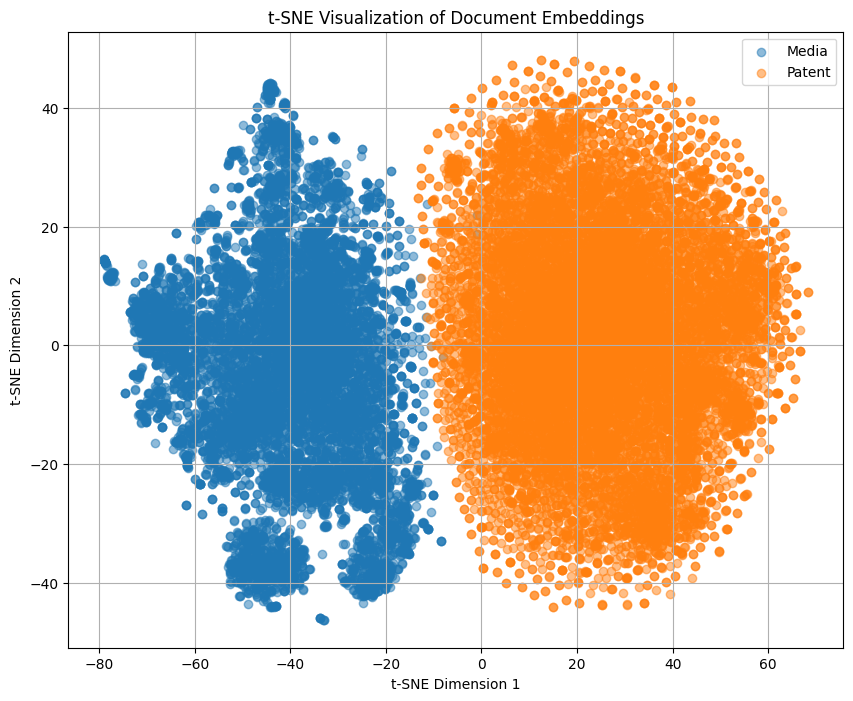

In [81]:
from sklearn.manifold import TSNE

# Combine embeddings from both datasets
combined_embeddings = np.vstack((media_embeddings, patent_embeddings))

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(combined_embeddings)

# Plot t-SNE embeddings
plt.figure(figsize=(10, 8))
plt.scatter(tsne_embeddings[:len(media_embeddings), 0], tsne_embeddings[:len(media_embeddings), 1], label='Media', alpha=0.5)
plt.scatter(tsne_embeddings[len(media_embeddings):, 0], tsne_embeddings[len(media_embeddings):, 1], label='Patent', alpha=0.5)
plt.title('t-SNE Visualization of Document Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

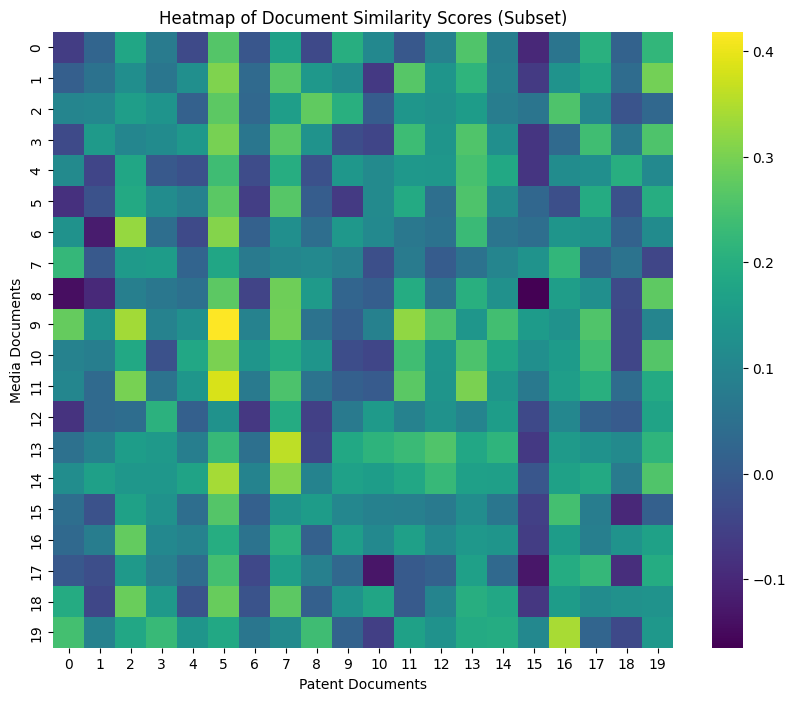

In [85]:
import seaborn as sns

# Select a subset of rows and columns
num_docs_to_display = 20  # Adjust this number as needed
subset_similarity_scores = similarity_scores[:num_docs_to_display, :num_docs_to_display]

# Create a heatmap of similarity scores for the subset
plt.figure(figsize=(10, 8))
sns.heatmap(subset_similarity_scores, cmap='viridis')
plt.title('Heatmap of Document Similarity Scores (Subset)')
plt.xlabel('Patent Documents')
plt.ylabel('Media Documents')
plt.show()

In [ ]:
from sklearn.cluster import KMeans

# Apply K-means clustering to embeddings
kmeans = KMeans(n_clusters=2, random_state=42)
media_clusters = kmeans.fit_predict(media_embeddings)
patent_clusters = kmeans.fit_predict(patent_embeddings)

# Plot clusters
plt.figure(figsize=(10, 8))
plt.scatter(tsne_media_embeddings[:, 0], tsne_media_embeddings[:, 1], c=media_clusters, cmap='viridis', label='Media', alpha=0.5)
plt.scatter(tsne_patent_embeddings[:, 0], tsne_patent_embeddings[:, 1], c=patent_clusters, cmap='viridis', label='Patent', alpha=0.5)
plt.title('Cluster Analysis of Document Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

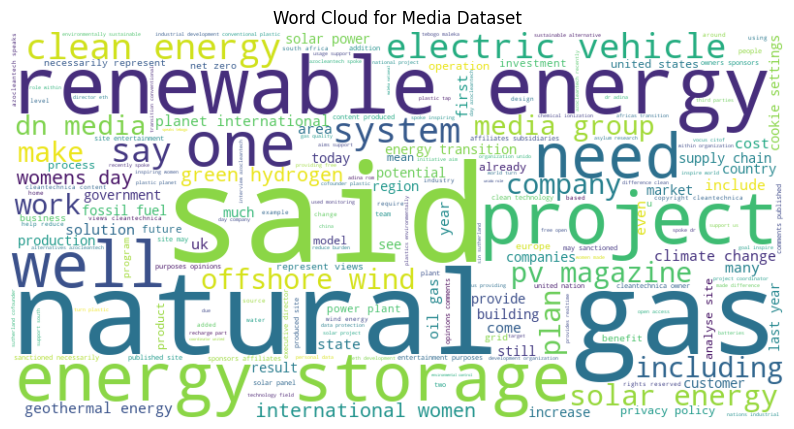

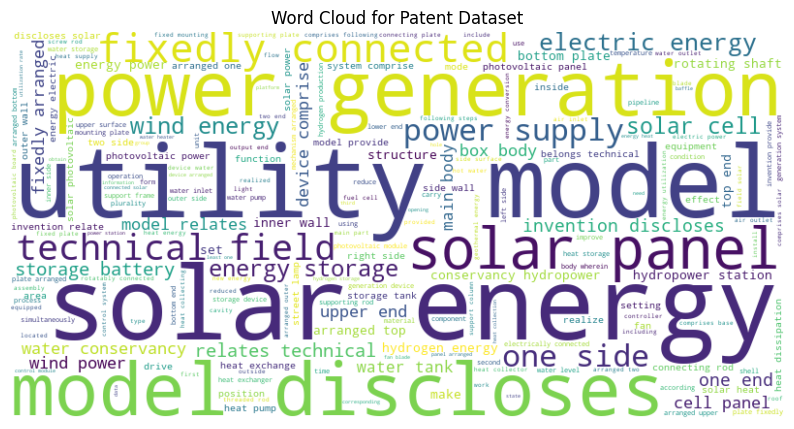

In [83]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to generate word cloud from tagged data
def generate_wordcloud(tagged_data, title):
    # Concatenate all words from the tagged data
    words = [word for doc in tagged_data for word in doc.words]
    # Join all words into a single string
    text = ' '.join(words)
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
    
    # Plot word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')  # Hide axis
    plt.show()

# Generate word cloud for media dataset
generate_wordcloud(tagged_data_media, title='Word Cloud for Media Dataset')

# Generate word cloud for patent dataset
generate_wordcloud(tagged_data_patent, title='Word Cloud for Patent Dataset')


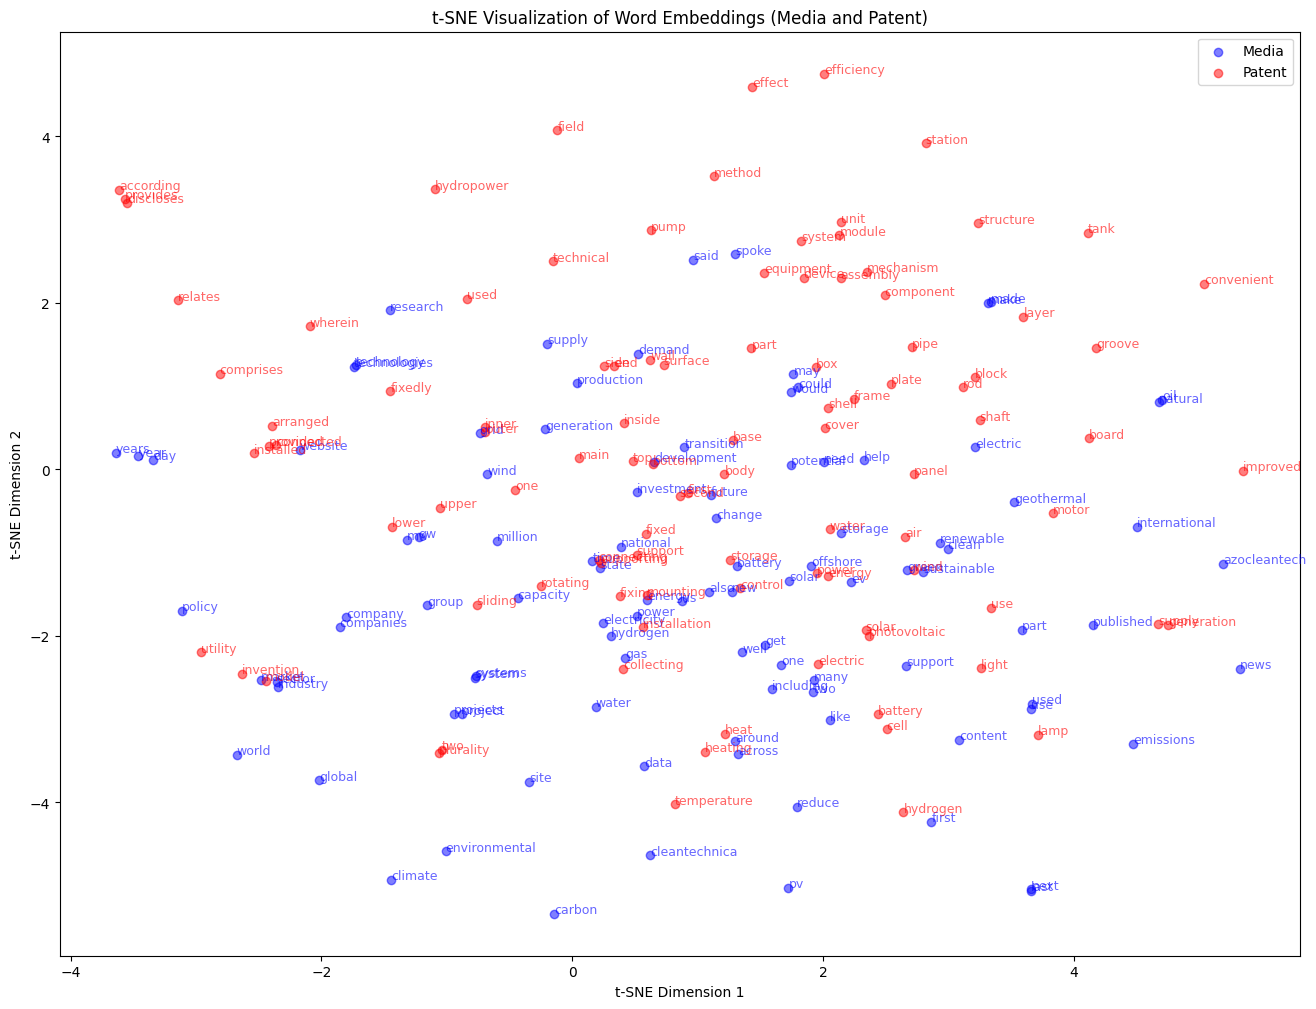

In [88]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Function to perform t-SNE dimensionality reduction for words
def tsne_word_embeddings(model, num_words):
    words = model.wv.index_to_key[:num_words]
    word_vectors = model.wv[words]
    tsne = TSNE(n_components=2, random_state=42)
    tsne_embeddings = tsne.fit_transform(word_vectors)
    return tsne_embeddings, words

# Perform t-SNE dimensionality reduction for media model
tsne_media_words, media_words = tsne_word_embeddings(model_media, num_words=100)

# Perform t-SNE dimensionality reduction for patent model
tsne_patent_words, patent_words = tsne_word_embeddings(model_patent, num_words=100)

# Plot t-SNE embeddings for both models
plt.figure(figsize=(16, 12))

plt.scatter(tsne_media_words[:, 0], tsne_media_words[:, 1], alpha=0.5, label='Media', c='blue')
plt.scatter(tsne_patent_words[:, 0], tsne_patent_words[:, 1], alpha=0.5, label='Patent', c='red')

# Annotate the points with the words for media
for i, word in enumerate(media_words):
    plt.annotate(word, (tsne_media_words[i, 0], tsne_media_words[i, 1]), fontsize=9, color='blue', alpha=0.6)

# Annotate the points with the words for patent
for i, word in enumerate(patent_words):
    plt.annotate(word, (tsne_patent_words[i, 0], tsne_patent_words[i, 1]), fontsize=9, color='red', alpha=0.6)

plt.title('t-SNE Visualization of Word Embeddings (Media and Patent)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()


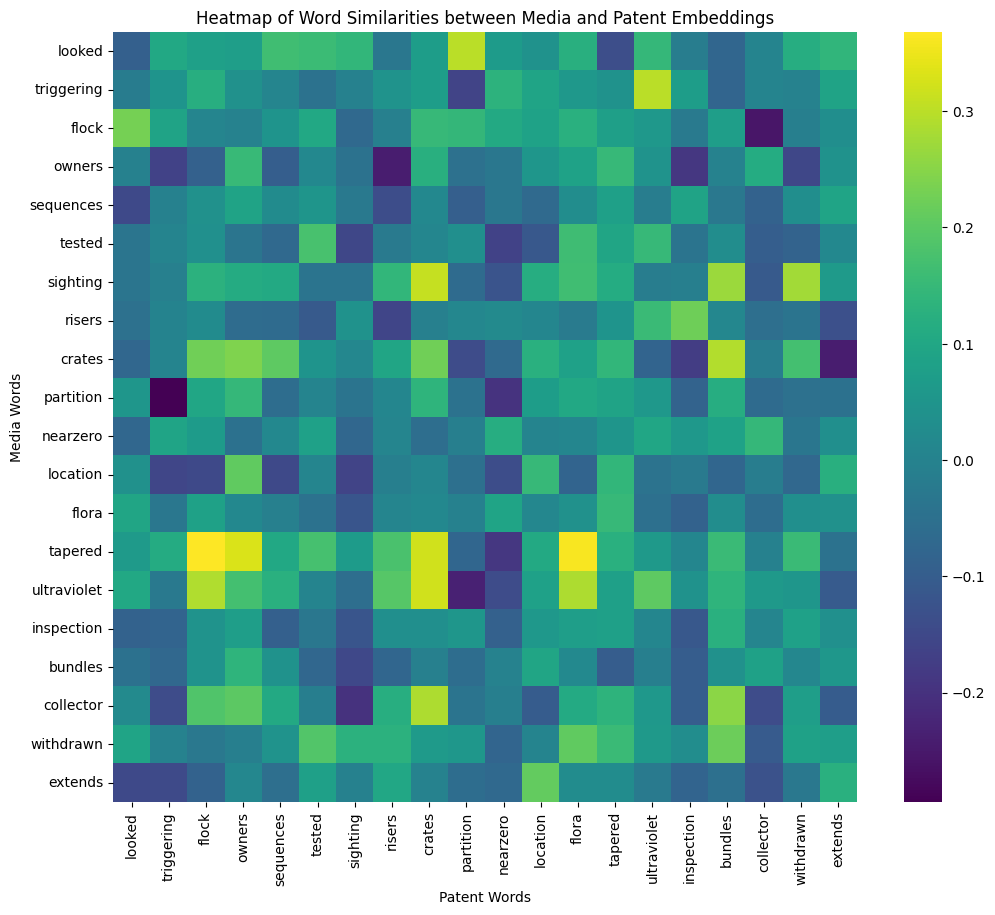

In [91]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Function to get common words and their similarity scores
def get_similarity_scores(model1, model2, common_words):
    vectors1 = np.array([model1.wv[word] for word in common_words])
    vectors2 = np.array([model2.wv[word] for word in common_words])
    
    similarity_matrix = cosine_similarity(vectors1, vectors2)
    return similarity_matrix

# Find common words in both models
common_words = set(model_media.wv.index_to_key).intersection(set(model_patent.wv.index_to_key))
common_words = list(common_words)[:20]  # Limiting to 50 common words for the heatmap

# Get similarity scores
similarity_scores = get_similarity_scores(model_media, model_patent, common_words)

# Create a DataFrame for the heatmap
similarity_df = pd.DataFrame(similarity_scores, index=common_words, columns=common_words)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(similarity_df, cmap='viridis', xticklabels=1, yticklabels=1, annot=False, fmt=".2f")
plt.title('Heatmap of Word Similarities between Media and Patent Embeddings')
plt.xlabel('Patent Words')
plt.ylabel('Media Words')
plt.show()


In [95]:
from collections import Counter
import pandas as pd
# Flatten the list of lists into a single list
def flatten_list(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

# Function to count word frequencies in the tagged data
def count_word_frequencies(tagged_data):
    word_counter = Counter()
    for doc in tagged_data:
        word_counter.update(doc)
    return word_counter

# Flatten the lists of lists into single lists
flattened_media_data = flatten_list(tagged_data_media)
flattened_patent_data = flatten_list(tagged_data_patent)

# Count word frequencies in media and patent datasets
media_word_freq = count_word_frequencies(flattened_media_data)
patent_word_freq = count_word_frequencies(flattened_patent_data)

# Create DataFrames for easy manipulation and visualization
media_df = pd.DataFrame(media_word_freq.items(), columns=['Word', 'Frequency (Media)'])
patent_df = pd.DataFrame(patent_word_freq.items(), columns=['Word', 'Frequency (Patent)'])

# Merge the two DataFrames to find common and unique words
merged_df = pd.merge(media_df, patent_df, on='Word', how='outer').fillna(0)
merged_df = merged_df.sort_values(by=['Frequency (Media)', 'Frequency (Patent)'], ascending=False).reset_index(drop=True)

# Display the merged DataFrame
print(merged_df.head(30))

           Word  Frequency (Media)  Frequency (Patent)
0        energy            62416.0             30098.0
1         solar            33435.0             28717.0
2           new            21002.0               882.0
3         power            20270.0             17987.0
4           gas            19139.0              1990.0
5            us            17957.0                 0.0
6          said            16949.0                94.0
7          also            15794.0              1380.0
8          data            14176.0              1693.0
9       project            14026.0               118.0
10      storage            13682.0             10152.0
11   geothermal            12747.0              1233.0
12     hydrogen            12552.0              4845.0
13   technology            12416.0               468.0
14         wind            12113.0              8468.0
15         year            11619.0                53.0
16  development            11609.0               219.0
17      co

In [98]:
def calculate_word_similarity(model1, model2, words):
    similarities = []
    for word in words:
        if word in model1.wv.key_to_index and word in model2.wv.key_to_index:
            similarity = model1.wv.similarity(word, word)
            similarities.append((word, similarity))
    return similarities

# Get common words from the merged DataFrame
common_words = merged_df['Word']

# Calculate similarities between common words in both models
word_similarities = calculate_word_similarity(model_media, model_patent, common_words)

# Convert to DataFrame for visualization
similarity_df = pd.DataFrame(word_similarities, columns=['Word', 'Similarity'])
similarity_df = similarity_df.sort_values(by='Similarity', ascending=False).reset_index(drop=True)

# Display the top similar words
print(similarity_df.head(30))


            Word  Similarity
0     activities         1.0
1          smash         1.0
2        command         1.0
3       entirely         1.0
4     smallsized         1.0
5           tube         1.0
6    exceptional         1.0
7      maximized         1.0
8          audio         1.0
9       wireless         1.0
10          tour         1.0
11       closeup         1.0
12        sucked         1.0
13       vectors         1.0
14      nitrogen         1.0
15      outgoing         1.0
16   watercooled         1.0
17  intersecting         1.0
18      protocol         1.0
19     watershed         1.0
20  availability         1.0
21          form         1.0
22   commonality         1.0
23     throttles         1.0
24       diagram         1.0
25        spaces         1.0
26   supervision         1.0
27      immunity         1.0
28          rand         1.0
29      scraping         1.0


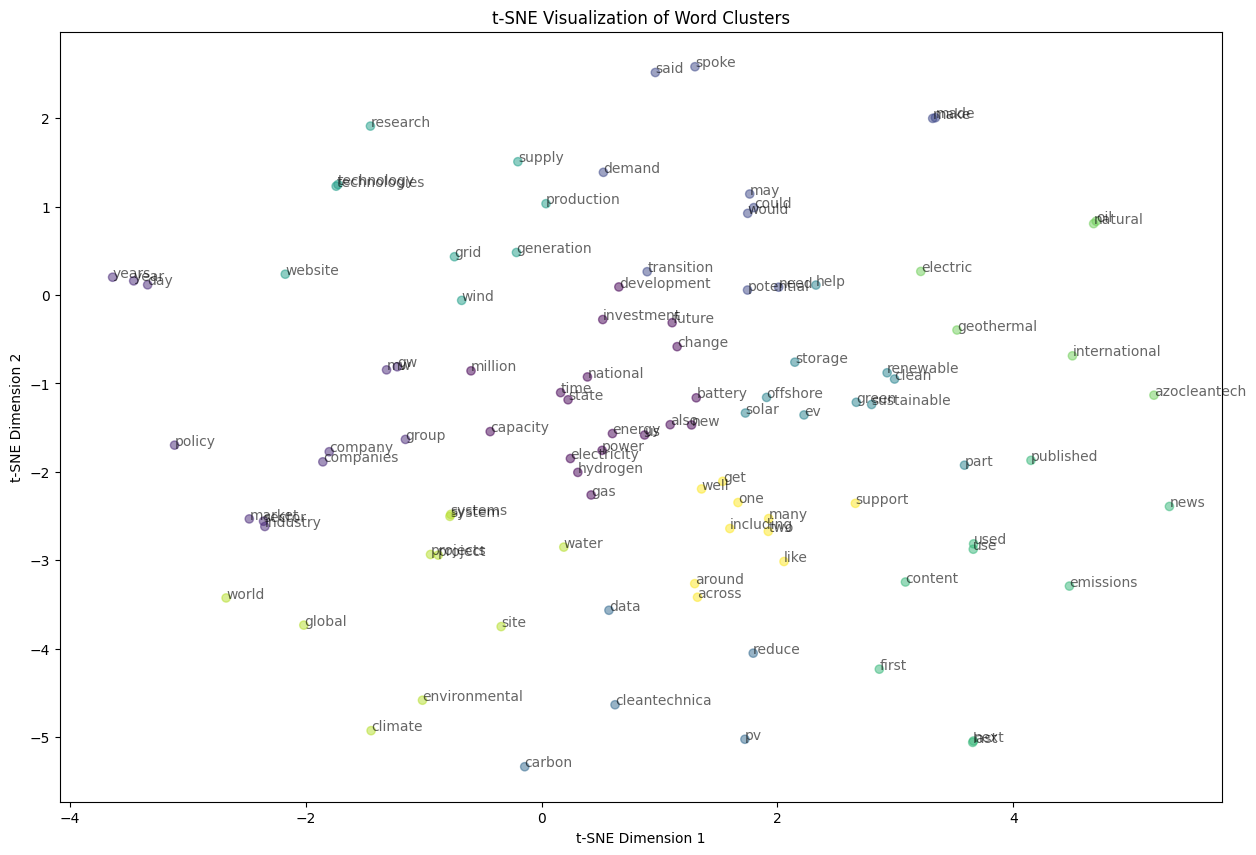

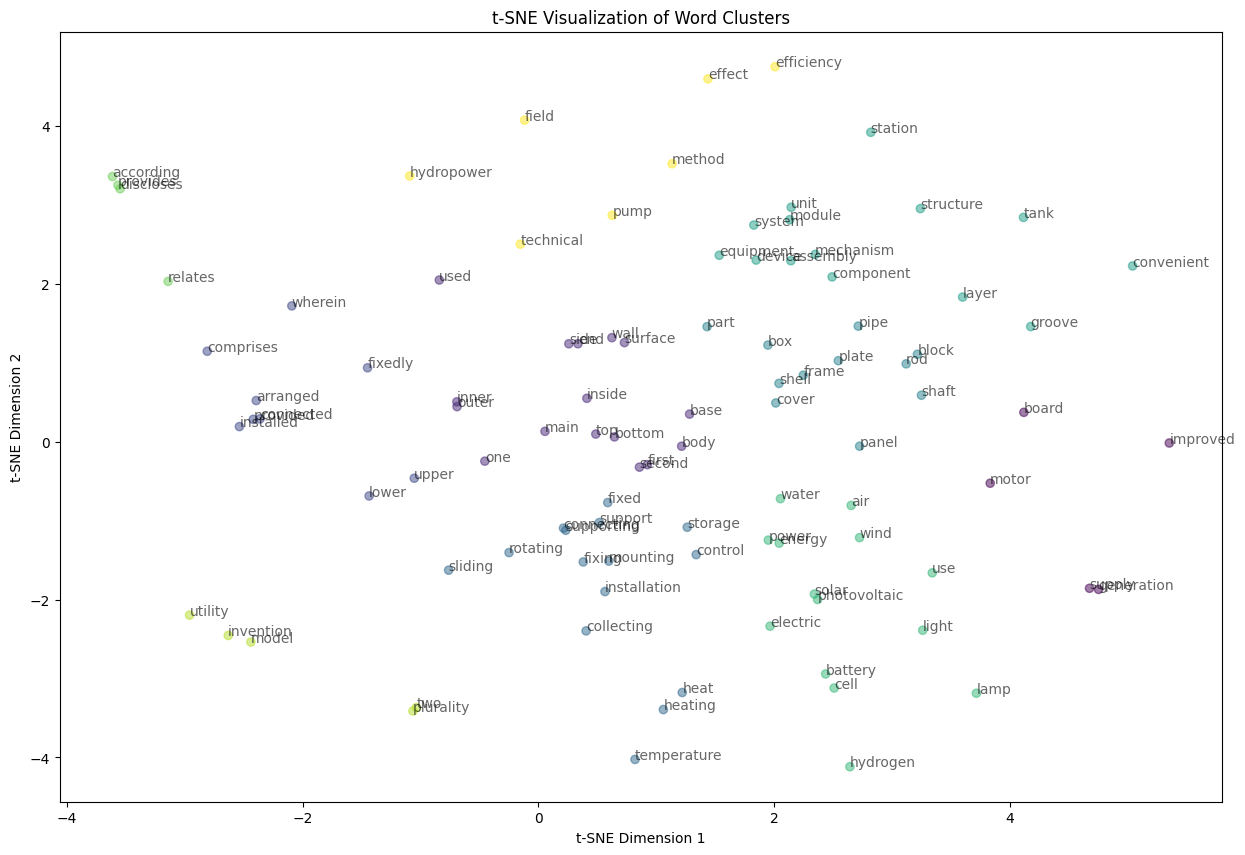

In [100]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Function to perform clustering and t-SNE visualization
def cluster_and_tsne_visualize(model, num_words, num_clusters):
    word_vectors = model.wv[model.wv.index_to_key[:num_words]]
    tsne = TSNE(n_components=2, random_state=42)
    tsne_embeddings = tsne.fit_transform(word_vectors)
    
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = kmeans.fit_predict(tsne_embeddings)
    
    plt.figure(figsize=(15, 10))
    plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=clusters, cmap='viridis', alpha=0.5)
    for i, word in enumerate(model.wv.index_to_key[:num_words]):
        plt.annotate(word, (tsne_embeddings[i, 0], tsne_embeddings[i, 1]), alpha=0.6)
    plt.title('t-SNE Visualization of Word Clusters')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

# Visualize clusters for media and patent models
cluster_and_tsne_visualize(model_media, num_words=100, num_clusters=10)
cluster_and_tsne_visualize(model_patent, num_words=100, num_clusters=10)


In [111]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Step 1: Embed the datasets
embedded_media_data = []
embedded_patent_data = []

# Flatten the list of lists and convert each data point to a single string
tagged_data_media_str = [' '.join(words) for data_point in tagged_data_media for words in data_point]
tagged_data_patent_str = [' '.join(words) for data_point in tagged_data_patent for words in data_point]

for data_point_str in tagged_data_media_str:
    embedded_vector = model_media.infer_vector(data_point_str.split())
    embedded_media_data.append(embedded_vector)

for data_point_str in tagged_data_patent_str:
    embedded_vector = model_patent.infer_vector(data_point_str.split())
    embedded_patent_data.append(embedded_vector)

# Convert embedded data to numpy arrays
embedded_media_data = np.array(embedded_media_data)
embedded_patent_data = np.array(embedded_patent_data)

# Step 2: Calculate Similarity
similarity_scores = cosine_similarity(embedded_media_data, embedded_patent_data)

# Step 3: Identify Thematic Overlaps
threshold = 0.8  # Define a threshold for similarity scores
overlaps = np.where(similarity_scores > threshold)

# Step 4: Analyze Differences
differences = np.where(similarity_scores < threshold)

# Step 5: Visualization
# Visualize using t-SNE for dimensionality reduction and plotting
tsne = TSNE(n_components=2, random_state=42)
embedded_media_data_tsne = tsne.fit_transform(embedded_media_data)
embedded_patent_data_tsne = tsne.fit_transform(embedded_patent_data)

# Scatter plot for thematic overlaps
plt.figure(figsize=(10, 5))
plt.scatter(embedded_media_data_tsne[:, 0], embedded_media_data_tsne[:, 1], label='Media Data', alpha=0.5)
plt.scatter(embedded_patent_data_tsne[:, 0], embedded_patent_data_tsne[:, 1], label='Patent Data', alpha=0.5)
plt.title('Thematic Overlaps')
plt.legend()
plt.show()

# Step 6: Domain Expertise Validation
# Further analysis or validation with domain experts as needed

